# Kaggle Titanic Baseline Processing

: 진행 순서 / 전처리 -> Logistic Regression &Metric  -> Naive Bayesian & Metric -> ROC Curve

## 0. 패키지, 데이터 프레임 불러오기

In [87]:
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import  linear_model
from sklearn import  preprocessing
from pandas.plotting import scatter_matrix
import tensorflow as tf
import seaborn as sns

- 각 데이터를 불러오는데 그냥 read_csv()를 통해 불러서 각각을 변수에 저장해준다.

In [88]:
load_train = pd.read_csv('./data/train.csv')
load_test = pd.read_csv('./data/test.csv')
load_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


- 학습 세트의 생존여부를 따로 빼서 저장해준다.

In [89]:
train_x = load_train.drop(['Survived'],axis=1) # axis=1은 수직이다. Column을 날려준다.
train_y = load_train.Survived

## 1. 데이터 살펴보기

- 시작 전에 학습 데이터의 간략한 요약 정보를 출력해본다.

In [90]:
load_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- 먼저 전처리 중에 Null값에 대한 판단을 해보려고 한다. 빈 값이 있는지 한번 열어본다. (Series 형에는 sort_values를 활용해야 한다.)
- DataFrame.count()를 하면 Null 값은 세지지 않기 때문에 .isnull().count()를 해야지 전체 값을 불러올 수 있다.

In [91]:
total = load_train.isnull().sum().sort_values(ascending=False)
percent =  (100*load_train.isnull().sum() / load_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Null_Value_Count', 'Percent'])
missing_data.head(5)

,Null_Value_Count,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467
Fare,0,0.000000
Ticket,0,0.000000


- 단순히, "DataFrame.isnull().count().sort_values(ascending=False)"를 통해서 빈 값이 몇 개나 존재하는 지 확인할 수 있다. 하지만 
- 중간중간 정보들을 변수에 저장해놓고 요약해놓음에 따라서 과정의 값들을 유지할 수 있고 직관적으로 확인해볼 수 있다. 
- 변수가 크지 않다면, 지우는 것보다 지속적으로 다른 변수를 선언해서 가공한 정보만을 저장해주는 게 좋다. 
- (중간중간에 되돌아와서 커널을 다시 돌리지 않아도 되고 헷갈리지않는다.)



- 결론적으로 결측치가 "1.Cabin / 2. Age / 3.Embarked" 순으로 존재한다는 걸 알 수 있었다.
- (결측치들은 소거 / 대체 로 대응할 수있다. 각 Feature에 대한 해석 후에 이를 판단하면 될 것으로 보인다.)



- 먼저 Cabin의 경우는 객실 번호다. 배의 위치에 따라서, 객실의 구명장비 유무에 따라서 다를 것으로 보이지만 현재는
-  추가적인 정보가 없기 때문에 결측치도 많고 무의미해 보이는 Cabin이란 속성은 소거해줘도 무방할 것으로 판단된다.


- 이렇 듯 판단이 가능하지만 현재, 각 속성 간의 상관관계를 우선 파악한 뒤에 판단하고자 한다.


In [92]:
corrmat = load_train.corr() #Correlation_Matrix
corrmat

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


- 판단한 속성 중에 'Survived'가 가장 중요한 속성이기 때문에 해당 매트릭스에서 'Survived'와 가장 연계가 높은 수 기준으로 Row를 뽑아준다.
- 그 다음 보기 편하게 index 값만 따로 뽑아서 보여준다. (마찬가지로 변수를 선언해준다.)

In [93]:
cols = corrmat.nlargest(10, 'Survived')['Survived']
print(cols)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64


- Survived 와 상관관계 높은순서는 <br></br>
- Fare , Parch , RassengerId , SibSp, Age , Pclass 하지만 가장높은 상관관계를 가지는 Fare 도 0.25정도

## 2. 결측값에 대한 대응

- 우선 결측치가 가장 높았던 Cabin을 먼저 대응해보고자 한다. 우선 직관적으로 보았을 땐, 생존여부와 상관없다고 판단된다.
- 상관관계는 숫자값이 아니였기 떄문에 파악할 수 없었다. 도식으로 표현한 뒤에 판단해보고자 한다. 값들은 제각각이고 0.5에
- 근접하여 크게 의미가 없어보인다. (후에 한꺼번에 날린 뒤 'Train_x'로 할당하고자 함)

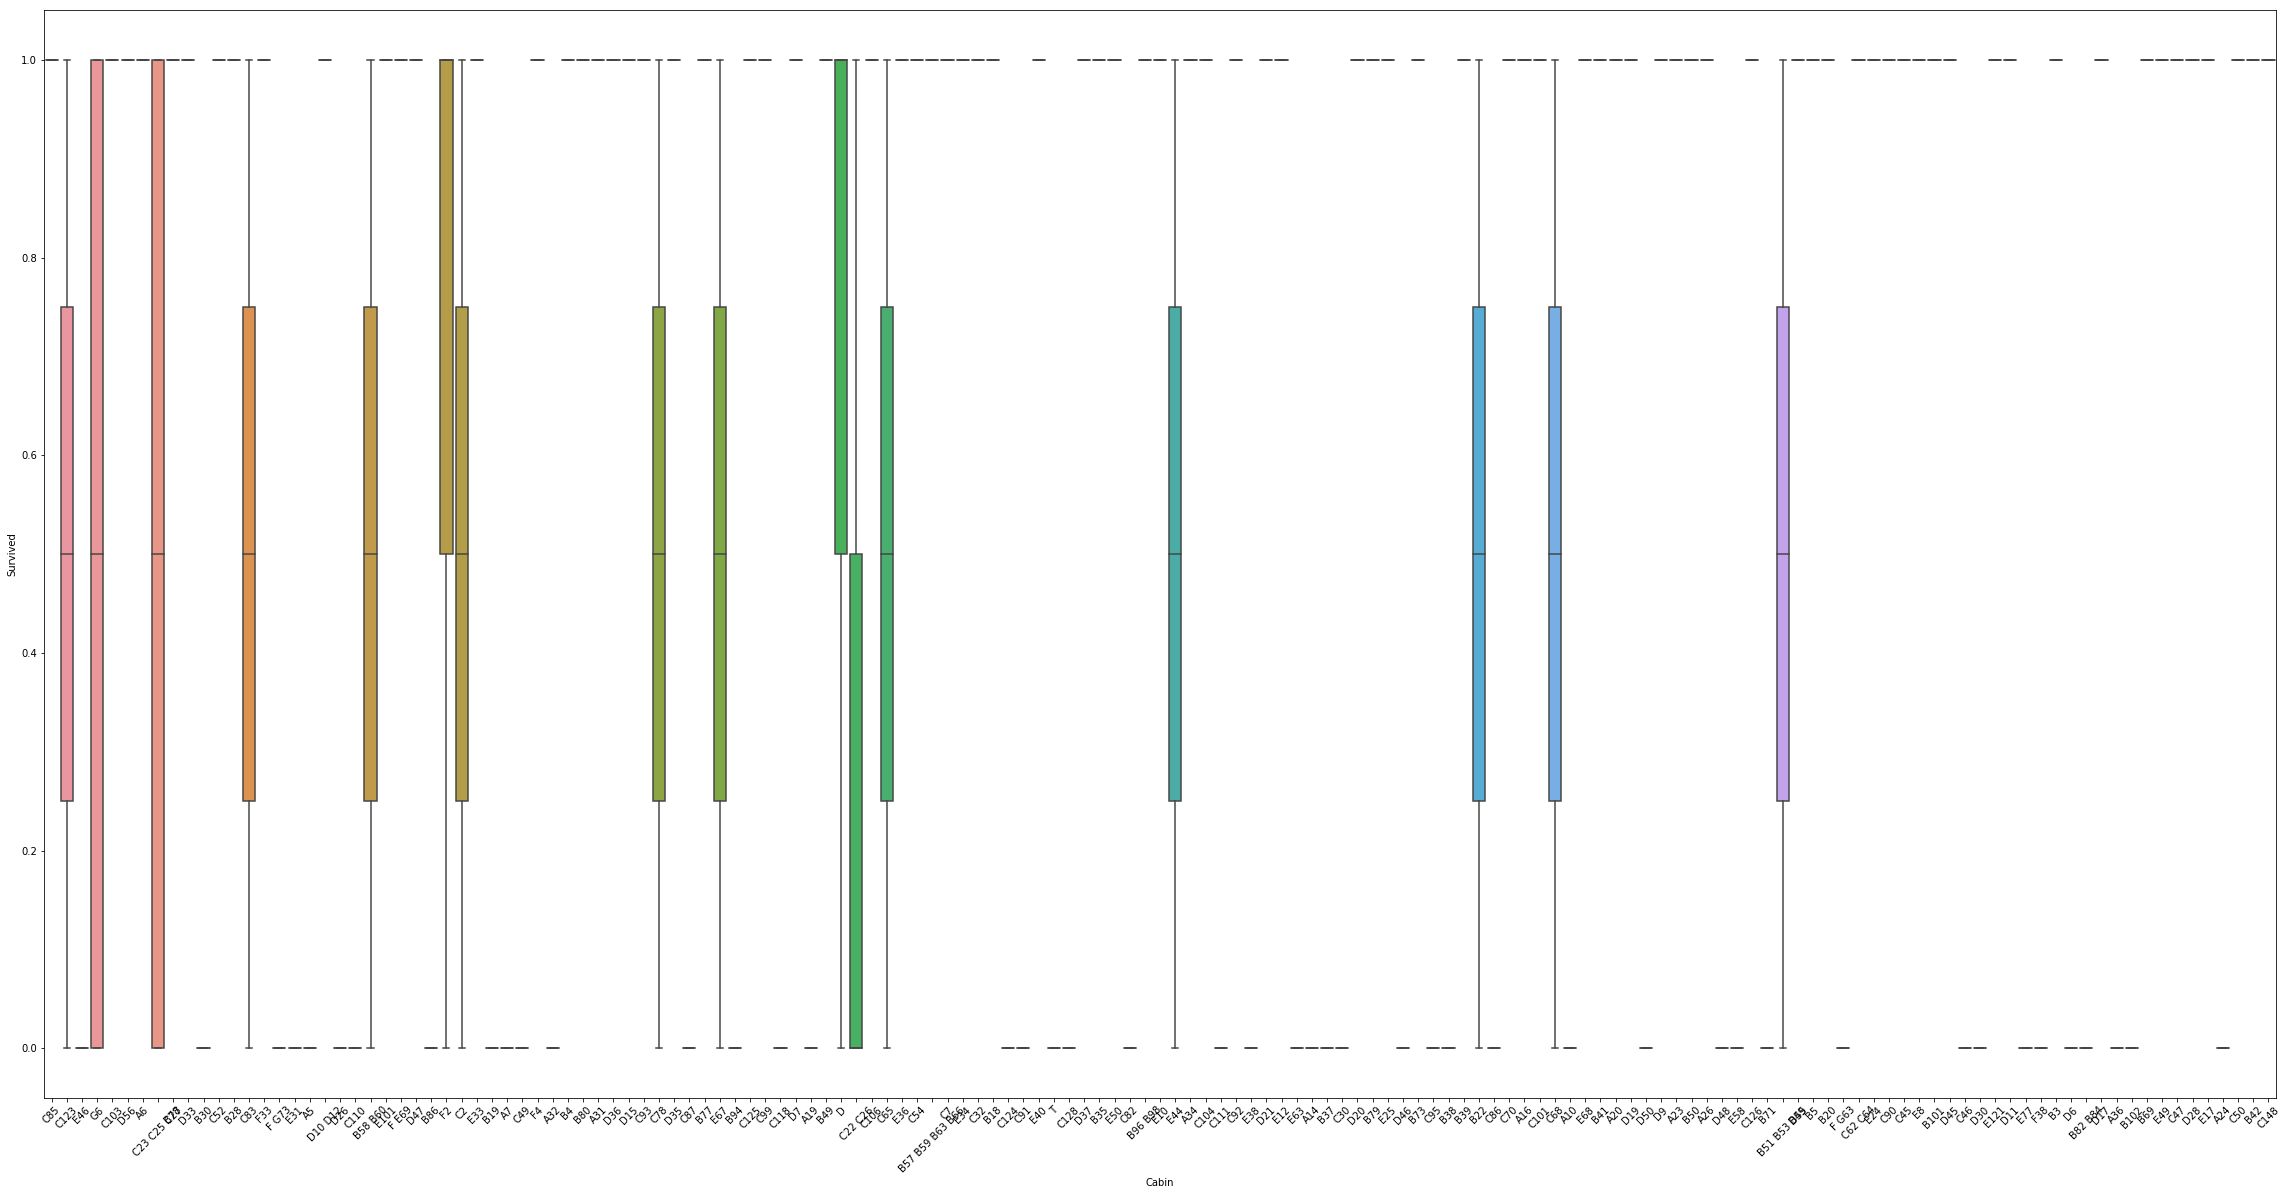

In [94]:
plt.figure(figsize = (40, 20))
sns.boxplot(x = 'Cabin', y = 'Survived',  data = load_train)
xt = plt.xticks(rotation=45)

- 다음으로는 'Age' 결측치에 대해서 대응해보고자 한다. 우선 상관관계에 절댓값을 씌워서 판단해보면 전체 중 3번째로 생존과
- 연관이 있는 -0.077221이라는 상관관계를 기록했다. 직관적으로 봤을 떈 나이에 따른 차이가 있어보인다. Box 도식 결과
- 생존을 가르는 연령대는 큰 차이는 없었으나 상대적으로 어린 연령대의 사람들이 생존하는 경향을 보였다. (평균치로 대응해도 될 것으로 보임)

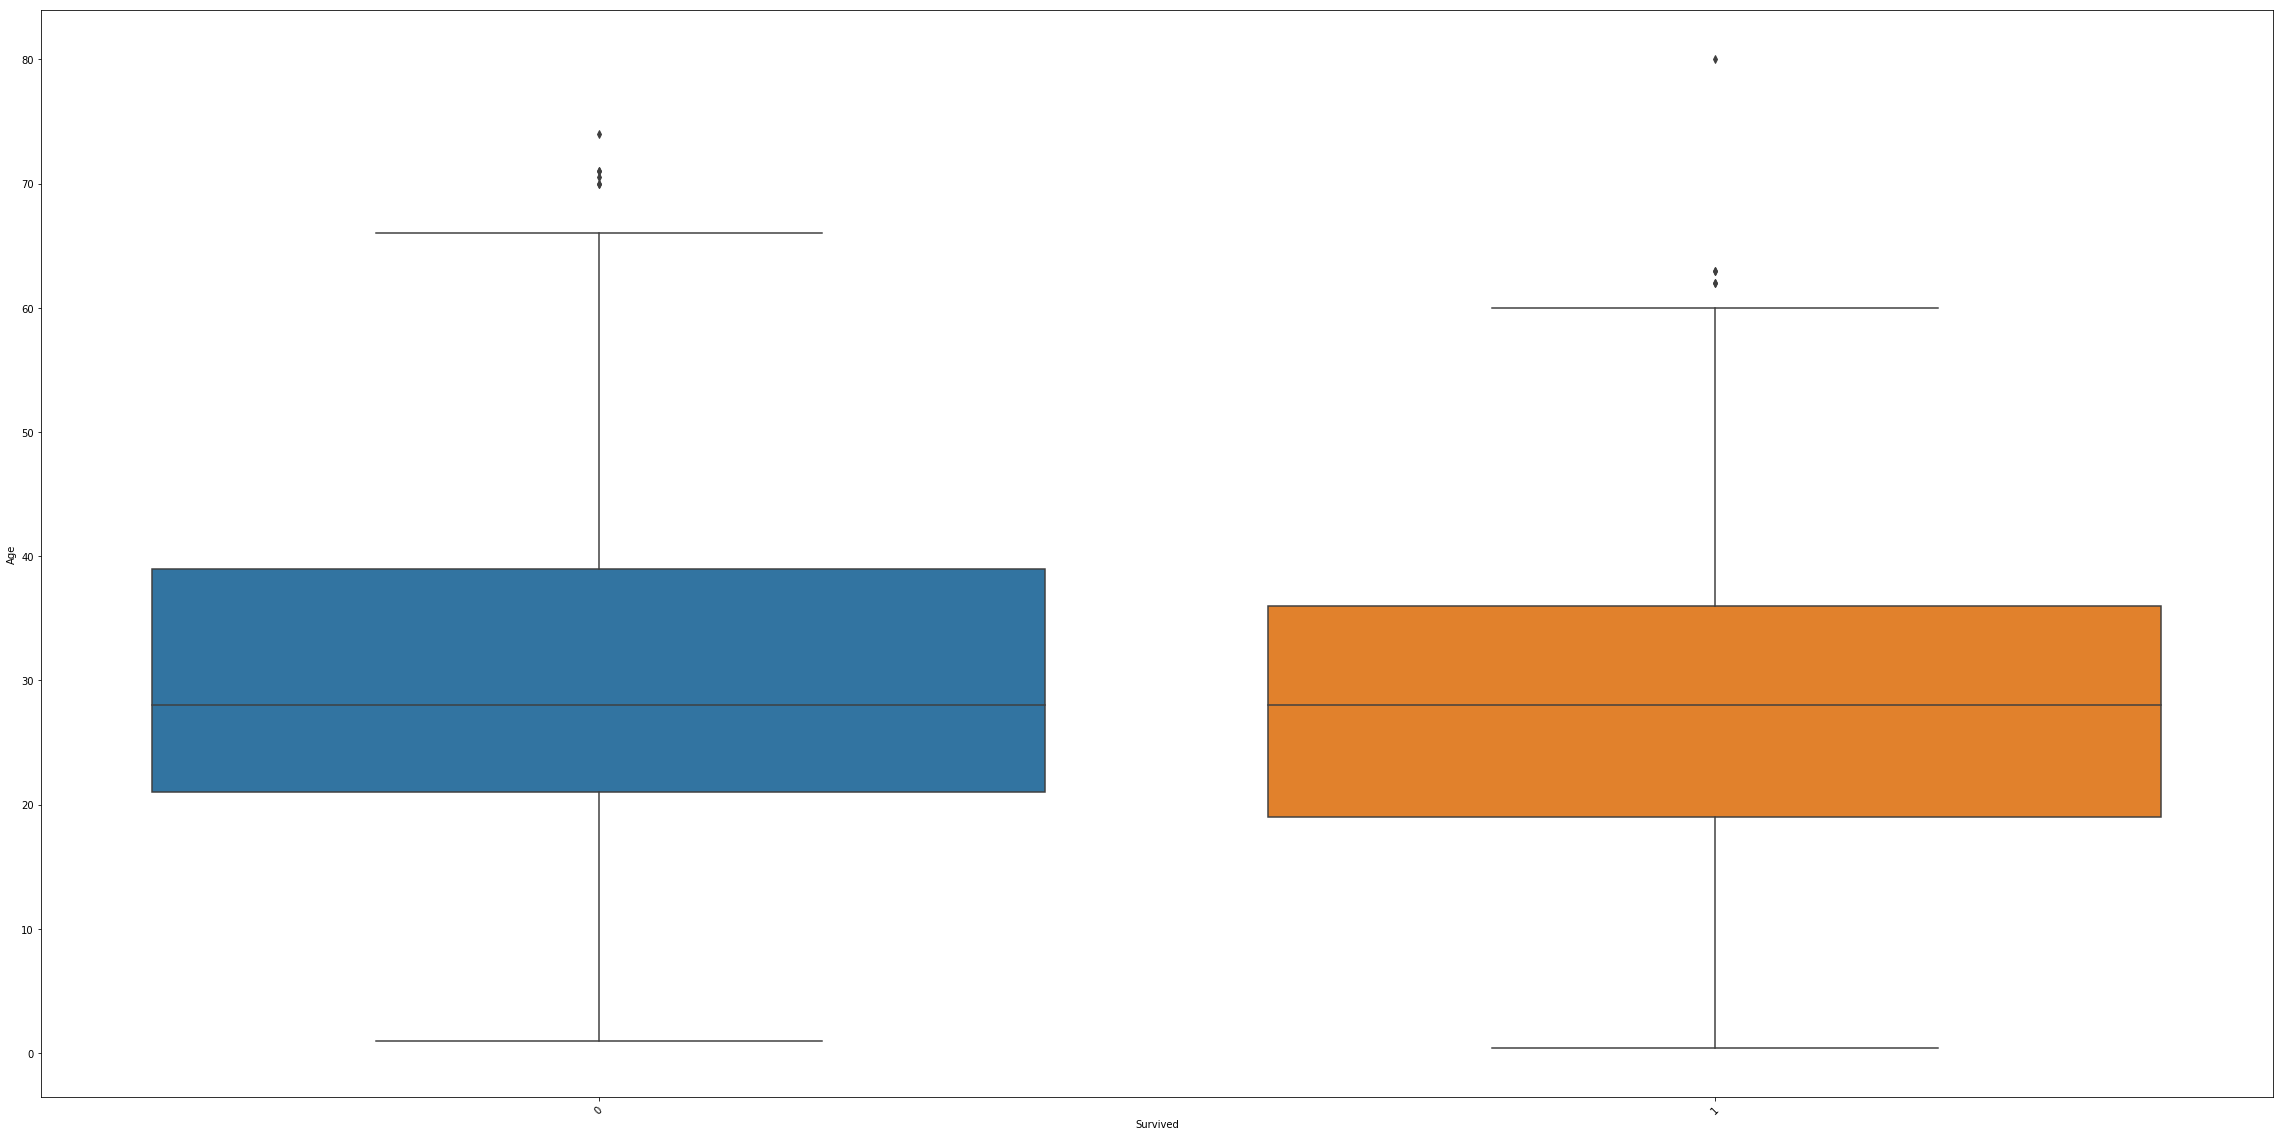

In [95]:
plt.figure(figsize = (40, 20))
sns.boxplot(x = 'Survived', y = 'Age',  data = load_train)
xt = plt.xticks(rotation=45)

In [96]:
load_train.Age = load_train.Age.fillna(load_train.Age.mean())
load_train.Age.isnull().sum()

0

- 마지막으로 'Embark' 즉 승선항에 대해서 판단을 하려고 한다. 우선, 해당 속성의 요약정보를 보면 'S'가 가장 많았고 결측치가 적기
- 떄문에 해당 값으로 결측치를 대체하고자 한다.

In [97]:
load_train.Embarked.describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [98]:
load_train.Embarked = load_train.Embarked.fillna('S')
load_train.Embarked.isnull().sum()

0

- 'Age'와 'Enbarked'에 대한 대처는 끝냈고 추가적으로 단순히 순서를 의미하는 'Passengerid', 목표 값인 'Survived', 티켓의 일련번호 인 
- 'Ticket', 'Cabin' 네 개의 속성은 "DataFrame.drop([Features],axis=1)"을 통해서 소거하고자 한다.

In [99]:
train_x = load_train.drop(['Ticket','PassengerId','Survived','Cabin'],axis=1)
train_y = load_train.Survived

- 다시금 결측치가 없는 지 확인해보면 다음과 같은 결과가 나온다.

In [100]:
train_x.isnull().sum()

Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

- 'Name'의 경우 get_dummies 사용하면 동명이인 외에는 각각 다른 값을 가지게 되므로 의미가 없어진다. 하지만
- 결혼 여부를 나타낼 수 있는 호칭 정보는 기재하면 의미가 있을 것으로 판단하여 유지하고자 한다.

In [101]:
for i in range(len(train_x.Name)):
    Passinger_Name =load_train.Name[i].split()
    if 'Mr.' in Passinger_Name :
        train_x.Name[i] = 'Mr.'
    elif 'Miss.' in Passinger_Name :
        train_x.Name[i] = 'Miss'
    elif 'Mrs.' in Passinger_Name :
        train_x.Name[i] = 'Mrs'
    elif 'Master.' in Passinger_Name :
        train_x.Name[i] = 'Master'
    else :
        train_x.Name[i] = 'nothing'

C:\Users\Kang\AppData\Local\conda\conda\envs\ml_scratch\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Kang\AppData\Local\conda\conda\envs\ml_scratch\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Kang\AppData\Local\conda\conda\envs\ml_scratch\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Kang\A

- 다음 정보를 보면 이름 내용이 다 줄어들고 Mr, Mrs, Miss 들이 남은 것을 알 수 있다.

In [102]:
train_x.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,Mr.,male,22.0,1,0,7.2500,S
1,1,Mrs,female,38.0,1,0,71.2833,C
2,3,Miss,female,26.0,0,0,7.9250,S
3,1,Mrs,female,35.0,1,0,53.1000,S
4,3,Mr.,male,35.0,0,0,8.0500,S


In [103]:
train_x.groupby(["Name"])["Name"].count()

Name
Master      40
Miss       182
Mr.        517
Mrs        125
nothing     27
Name: Name, dtype: int64

- 이름 중에 딱히 Mr,Mrs,Miss,Master 등의 호칭이 없어서 'nothing'인 인원들은 다음과 같다.

In [104]:
load_train[train_x["Name"]=='nothing']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
30,31,0,1,"Uruchurtu, Don. Manuel E",male,40.000000,0,0,PC 17601,27.7208,NaN,C
149,150,0,2,"Byles, Rev. Thomas Roussel Davids",male,42.000000,0,0,244310,13.0000,NaN,S
150,151,0,2,"Bateman, Rev. Robert James",male,51.000000,0,0,S.O.P. 1166,12.5250,NaN,S
245,246,0,1,"Minahan, Dr. William Edward",male,44.000000,2,0,19928,90.0000,C78,Q
249,250,0,2,"Carter, Rev. Ernest Courtenay",male,54.000000,1,0,244252,26.0000,NaN,S
317,318,0,2,"Moraweck, Dr. Ernest",male,54.000000,0,0,29011,14.0000,NaN,S
369,370,1,1,"Aubart, Mme. Leontine Pauline",female,24.000000,0,0,PC 17477,69.3000,B35,C
398,399,0,2,"Pain, Dr. Alfred",male,23.000000,0,0,244278,10.5000,NaN,S
443,444,1,2,"Reynaldo, Ms. Encarnacion",female,28.000000,0,0,230434,13.0000,NaN,S
449,450,1,1,"Peuchen, Major. Arthur Godfrey",male,52.000000,0,0,113786,30.5000,C104,S


- 이제 명목 척도들을 "pd.get_dummies(DataFrame)"을 통해서 1,0으로 이루어지도록 변경해주어서 학습시킬 준비를 한다.

In [105]:
train_x.Pclass = load_csv.Pclass.astype(str)
train_x = pd.get_dummies(train_x)
print(len(train_x))
train_x.head()

891


,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Name_Master,Name_Miss,Name_Mr.,Name_Mrs,Name_nothing,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,22.0,1,0,7.2500,0,0,1,0,0,1,0,0,0,1,0,0,1
1,38.0,1,0,71.2833,0,0,1,0,0,0,1,0,1,0,1,0,0
2,26.0,0,0,7.9250,0,1,0,0,1,0,0,0,1,0,0,0,1
3,35.0,1,0,53.1000,0,0,1,0,0,0,1,0,1,0,0,0,1
4,35.0,0,0,8.0500,0,0,1,0,0,1,0,0,0,1,0,0,1


In [106]:
train_cols = train_x.columns

## 3. 데이터 학습 및 정확도 측정

- 우선 필요한 사이킷런에서 제공하는 세 가지 스케일링 방법을 가져온다.

In [107]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler ,normalize
from sklearn import preprocessing

- 다음으로는 정확도 검증을 위한 Train과 Test Set을 8:2의 비율로 분할하여 관리하고자 한다.

In [108]:
min_max_scaler = preprocessing.MinMaxScaler()
train_x = min_max_scaler.fit_transform(train_x)

train_x = train_x[:int(len(train_x)*0.8)]
test_x = train_x[int(len(train_x)*0.8):]

train_y = train_y[:int(len(train_y)*0.8)]
test_y = train_y[int(len(train_y)*0.8):]

In [109]:
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier

In [110]:
clf1 = LogisticRegression(penalty='l2',C=0.001,random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1,criterion='entropy',random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1,p=2,metric='minkowski')
clf4 = MLPClassifier(hidden_layer_sizes=(500,),learning_rate_init=0.002,alpha=0.01,max_iter=500)
clf5 = RandomForestClassifier(n_jobs=-1)
clf6 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200)


pipe1 = Pipeline([['sc',MinMaxScaler()],['clf',clf1]])
pipe3 = Pipeline([['sc',MinMaxScaler()],['clf',clf3]])
pipe4 = Pipeline([['sc',MinMaxScaler()],['clf',clf4]])


clf_label=['Logistic Regression','Decision Tree','KNN','MLPClassifier','RandomForest','Adaboost']
print('10-fold cross validation:\n')
for clf, label in zip([pipe1,clf2,pipe3,pipe4,clf5,clf6],clf_label):
    scores =cross_val_score(estimator=clf,
                           X=train_x,
                           y=train_y,
                           cv=10,
                           scoring='roc_auc')
    print("ROC AUC : %0.2f (+/- %0.2f) [%s]\n"%(scores.mean(),scores.std(),label))
        
    
eclf1 = VotingClassifier(estimators=[('lr', pipe1), ('rf', clf2), ('gnb', pipe3),('nlp',pipe4),('rd',clf5),('ada',clf6)], 
                         voting='soft',n_jobs=-1)    
eclf1 = eclf1.fit(train_x, train_y)

print('Ensenble 10-fold cross validation:\n')
scores =cross_val_score(estimator=eclf1,X=train_x, y=train_y,cv=10,scoring='roc_auc')
print("Ensemble AUC : %0.2f (+/- %0.2f) [%s]\n"%(scores.mean(),scores.std(),'Ensemble model'))
    
print(classification_report(test_y,eclf1.predict(test_x)))

10-fold cross validation:

ROC AUC : 0.80 (+/- 0.06) [Logistic Regression]

ROC AUC : 0.77 (+/- 0.06) [Decision Tree]

ROC AUC : 0.69 (+/- 0.05) [KNN]

ROC AUC : 0.84 (+/- 0.05) [MLPClassifier]

ROC AUC : 0.84 (+/- 0.06) [RandomForest]

ROC AUC : 0.84 (+/- 0.05) [Adaboost]

Ensenble 10-fold cross validation:

Ensemble AUC : 0.83 (+/- 0.05) [Ensemble model]

             precision    recall  f1-score   support

          0       0.91      1.00      0.96        86
          1       1.00      0.86      0.92        57

avg / total       0.95      0.94      0.94       143



C:\Users\Kang\AppData\Local\conda\conda\envs\ml_scratch\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [111]:
#test data
load_csv = pd.read_csv('./data/test.csv')
load_csv.head()
load_csv.Pclass = load_csv.Pclass.astype(str)

In [112]:
load_csv.Age = load_csv.Age.fillna(load_csv.Age.mean())

In [113]:
load_csv.Fare = load_csv.Fare.fillna(load_csv.Fare.mean())

In [114]:
for i in range(len(load_csv.Name)):
    a =load_csv.Name[i].split()
    if 'Mr.' in a :
        load_csv.Name[i] = 'Mr.'
    elif 'Miss.' in a :
        load_csv.Name[i] = 'Miss'
    elif 'Mrs.' in a :
        load_csv.Name[i] = 'Mrs'
    elif 'Master.' in a :
        load_csv.Name[i] = 'Master'
    else :
        load_csv.Name[i] = 'nothing'

C:\Users\Kang\AppData\Local\conda\conda\envs\ml_scratch\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Kang\AppData\Local\conda\conda\envs\ml_scratch\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Kang\AppData\Local\conda\conda\envs\ml_scratch\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Kang\A

In [115]:
ID = load_csv.PassengerId

In [116]:
test_set = load_csv.drop(['PassengerId','Cabin','Ticket'],axis=1)

In [117]:
test_set.head(10)

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,Mr.,male,34.5,0,0,7.8292,Q
1,3,Mrs,female,47.0,1,0,7.0000,S
2,2,Mr.,male,62.0,0,0,9.6875,Q
3,3,Mr.,male,27.0,0,0,8.6625,S
4,3,Mrs,female,22.0,1,1,12.2875,S
5,3,Mr.,male,14.0,0,0,9.2250,S
6,3,Miss,female,30.0,0,0,7.6292,Q
7,2,Mr.,male,26.0,1,1,29.0000,S
8,3,Mrs,female,18.0,0,0,7.2292,C
9,3,Mr.,male,21.0,2,0,24.1500,S


In [118]:
test_set = pd.get_dummies(test_set)

In [119]:
test_set = min_max_scaler.fit_transform(test_set)

In [120]:
test_set

array([[0.4527232 , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.61756561, 0.125     , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.8153765 , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.50547277, 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.39697468, 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.39697468, 0.125     , 0.11111111, ..., 1.        , 0.        ,
        0.        ]])

In [121]:
predict = eclf1.predict(test_set)

C:\Users\Kang\AppData\Local\conda\conda\envs\ml_scratch\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [122]:
test = pd.DataFrame( { 'PassengerId': ID , 'Survived': predict } )
test.shape
test.head()
test.to_csv( './predict/titanic_pred.csv' , index = False )